In [1]:
#Need this to add libraries in parent folder
import sys
sys.path.append('..')
sys.path.append('.')
sys.path.append('../lib')

In [2]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv
import lib.plot.table as plttbl

import os
import math
import numpy as np

In [93]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)
importlib.reload(plttbl)

<module 'lib.plot.table' from '../lib/plot/table.py'>

### Load data

In [4]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input('../analysisinput.txt')
#path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path='../M06_th45'

In [120]:
numframe

2000

In [5]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

### transform frame

In [6]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields
dflow = ft.transform_flow(dflow,vshock)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


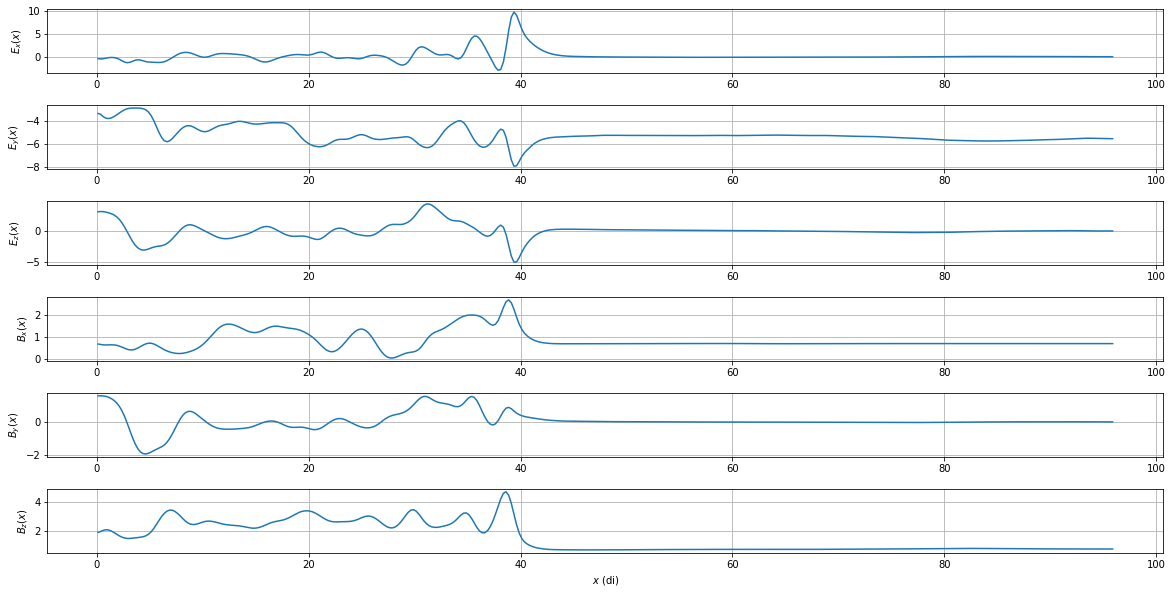

In [7]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### select x region to analyze

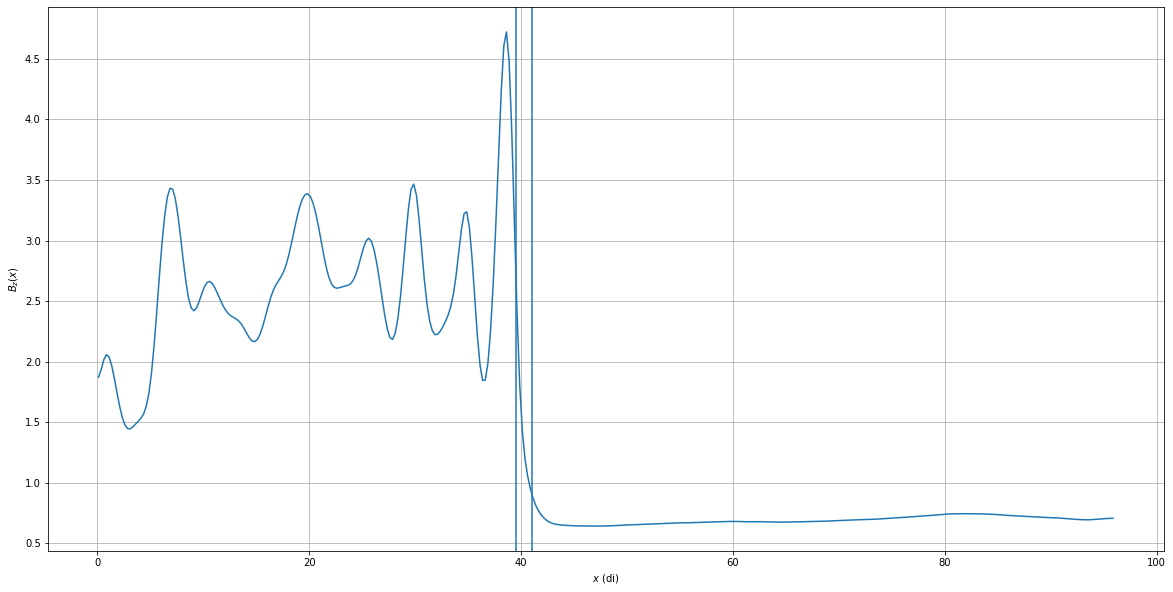

In [8]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startvalramp = 39.5#lower bound for metadata = 1 (di)
endvalramp = 41. #upper bound for metadata = 1 (di)

midrampx = (startvalramp+endvalramp)/2.
midrampidx = ao.find_nearest(dfields['bz_xx'],midrampx)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startvalramp, axvx2 = endvalramp)

### get fluctuations

In [9]:
dflow.keys()

dict_keys(['ux', 'ux_xx', 'ux_yy', 'ux_zz', 'uy', 'uy_xx', 'uy_yy', 'uy_zz', 'uz', 'uz_xx', 'uz_yy', 'uz_zz', 'id', 'Vframe_relative_to_sim'])

In [10]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)
dflowfluc = anl.remove_average_flow_over_yz(dflow)

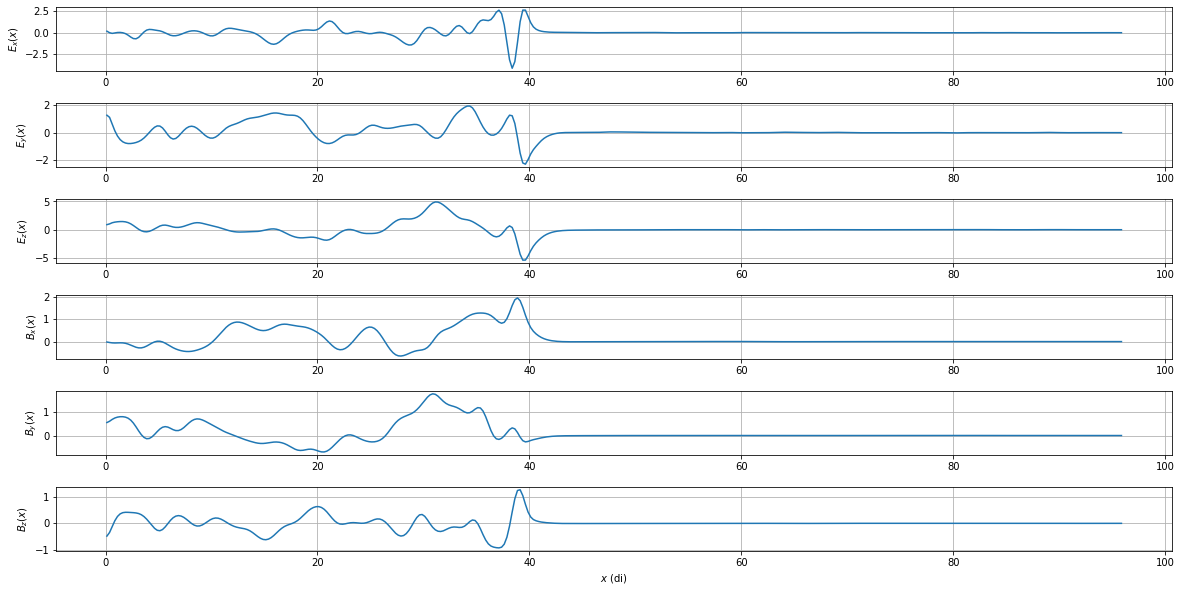

In [11]:
plt1d.plot_all_fields(dfieldsfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### get relevant subset

In [12]:
dfieldssubset = ao.get_field_subset(dfields,startvalramp,endvalramp,0.,12.,0.,12.)
dflowsubsset = ao.get_flow_subset(dflow,startvalramp,endvalramp,0.,12.,0.,12.)

dfieldflucsubset = ao.get_field_subset(dfieldsfluc,startvalramp,endvalramp,0.,12.,0.,12.)
dflowflucsubsset = ao.get_flow_subset(dflowfluc,startvalramp,endvalramp,0.,12.,0.,12.)

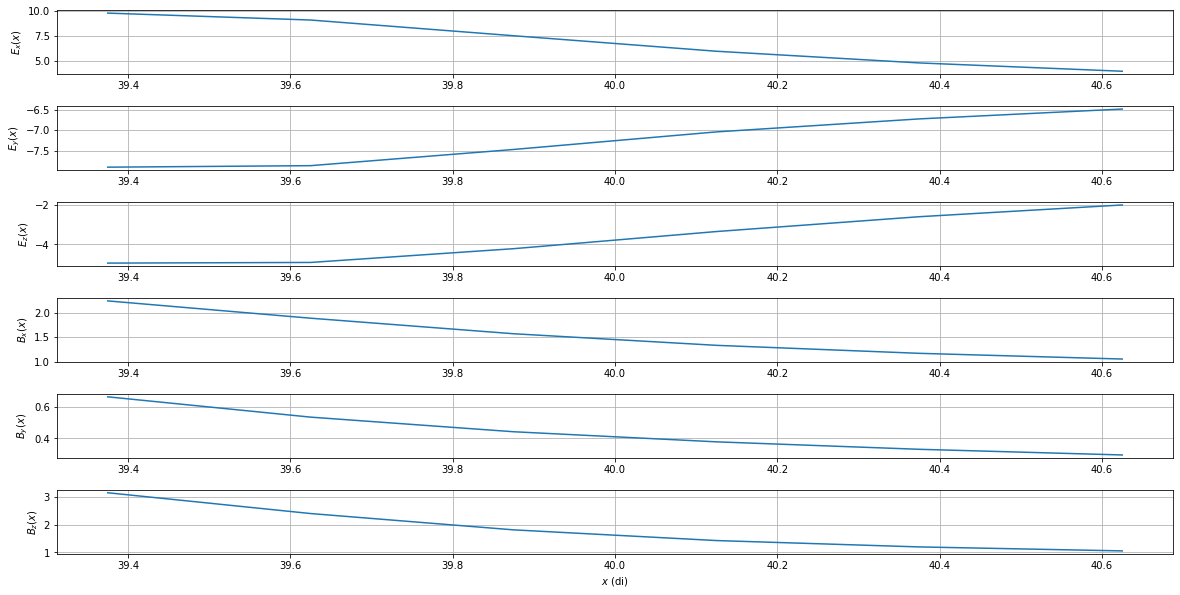

In [13]:
plt1d.plot_all_fields(dfieldssubset, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### look at average yz averaged fields

In [14]:
dfieldsavg = anl.get_average_fields_over_yz(dfields)

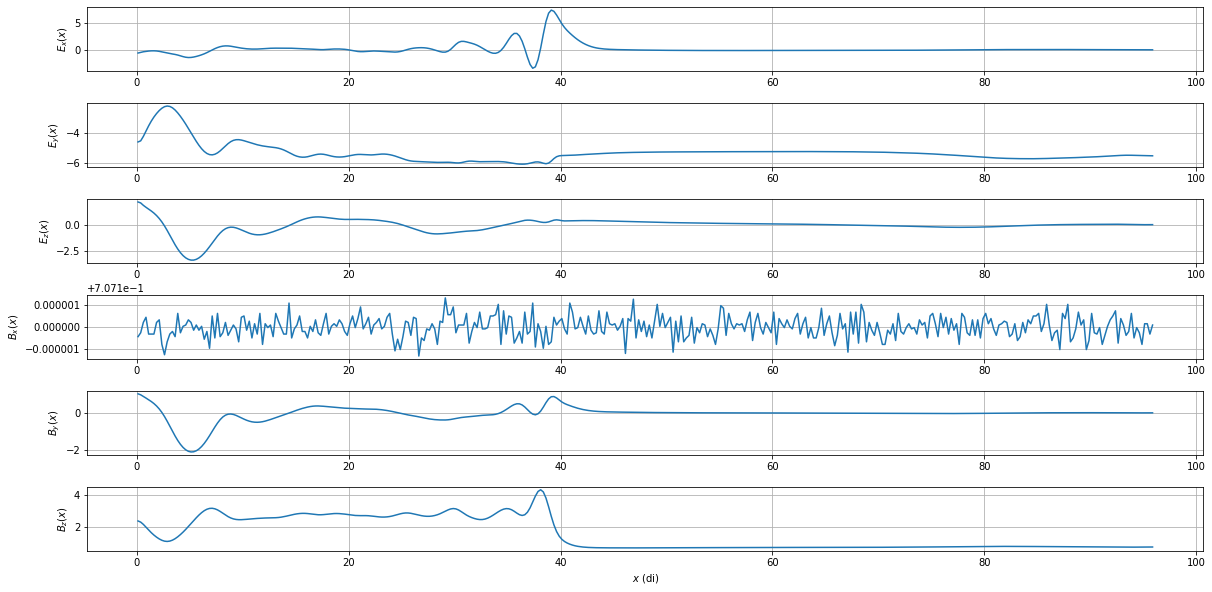

In [15]:
plt1d.plot_all_fields(dfieldsavg, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Take FFT

In [16]:
fftbx = np.fft.fftn(dfieldflucsubset['bx'])
fftby = np.fft.fftn(dfieldflucsubset['by'])
fftbz = np.fft.fftn(dfieldflucsubset['bz'])
fftex = np.fft.fftn(dfieldflucsubset['ex'])
fftey = np.fft.fftn(dfieldflucsubset['ey'])
fftez = np.fft.fftn(dfieldflucsubset['ez'])
fftux = np.fft.fftn(dflowflucsubsset['ux'])
fftuy = np.fft.fftn(dflowflucsubsset['uy'])
fftuz = np.fft.fftn(dflowflucsubsset['uz'])

### Test Wavelet Transform over xx

In [17]:
#first calculate Bi(x,ky,kz) (or Ei(x,ky,kz))
fieldkey = 'bz'

In [18]:
#spacing in grids, needed to get wavenumber from fft
daxis0 = dfieldsfluc[fieldkey+'_zz'][1]-dfieldsfluc[fieldkey+'_zz'][0]
daxis1 = dfieldsfluc[fieldkey+'_yy'][1]-dfieldsfluc[fieldkey+'_yy'][0]

fieldfftsweepoverx = []
for xxindex in range(0,len(dfieldsfluc[fieldkey][0][0])):
    fieldslice = np.asarray(dfieldsfluc[fieldkey])[:,:,xxindex]
    kz, ky, fieldslicefft = anl.take_fft2(fieldslice,daxis0,daxis1)
    fieldfftsweepoverx.append(fieldslicefft)
fieldfftsweepoverx = np.asarray(fieldfftsweepoverx)

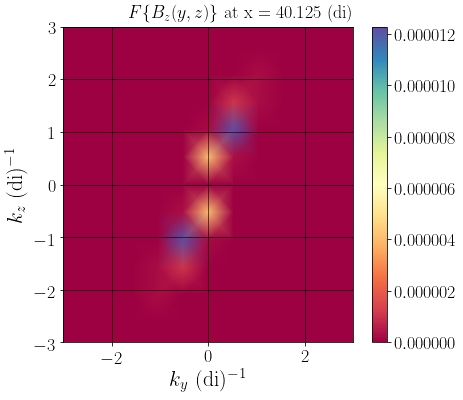

In [19]:
pltfr.plot_fft_norm(dfieldsfluc, fieldkey,'yz', takeaxisaverage=False, xxindex=midrampidx, plotlog=False,xaxislim=3,yaxislim=3) 

(Pick one of the following options to find a kyidx and kzidx that we are going to be analyzing)

##### option 1

In [20]:
#pick ky kz by using max
kyidx, kzidx = np.unravel_index(np.argmax(fieldfftsweepoverx[midrampidx], axis=None), fieldfftsweepoverx[midrampidx].shape)

##### option 2

In [21]:
# #hand pick ky, kz using above plot
kyidx = ao.find_nearest(ky,1.047)
kzidx = ao.find_nearest(kz,.5235)

In [22]:
#take slice at given ky kz
xkykzdata = fieldfftsweepoverx[:,kzidx,kyidx] #TODO: Double check if ky and kz should be flipped
ky0 = ky[kyidx]
kz0 = kz[kzidx]

In [23]:
ky0

1.0471975511965976

In [24]:
kz0

0.5235987755982988

In [25]:
dfields['bz'][1,2,4]

2.046367

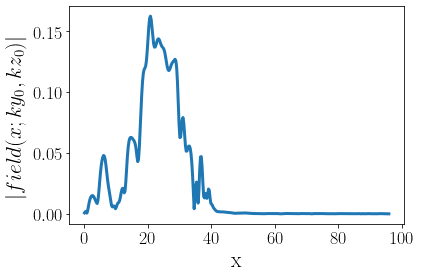

In [26]:
#plot norm
import matplotlib.pyplot as plt
temp = np.absolute(xkykzdata)
plt.figure()
plt.ylabel('$|field(x;ky_0,kz_0)|$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

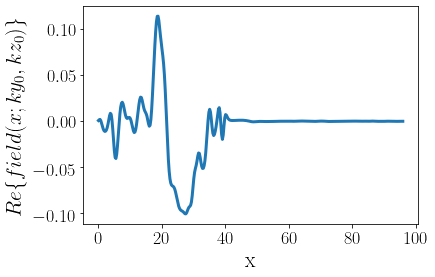

In [27]:
#plot real component
import matplotlib.pyplot as plt
temp = np.real(xkykzdata)
plt.figure()
plt.ylabel('$Re\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

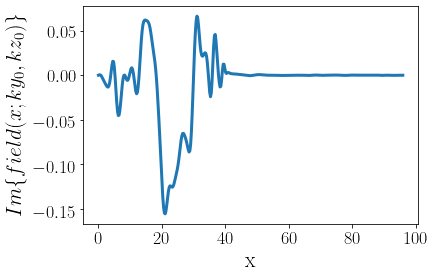

In [28]:
#plot imag component
import matplotlib.pyplot as plt
temp = np.imag(xkykzdata)
plt.figure()
plt.ylabel('$Im\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

In [29]:
dfields['bz'][1,2,4]

2.046367

### Test Wavelet Transform over xx

In [30]:
kx, wlt = anl.wlt(dfieldsfluc[fieldkey+'_xx'],xkykzdata)

In [31]:
dfields['bz'][1,2,4]

2.046367

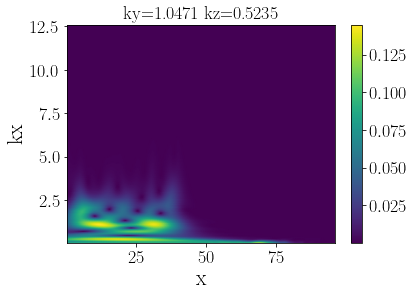

In [32]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],kx,np.abs(wlt),cmap='viridis', shading='gouraud')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
plt.title('ky='+str(ky0)[0:6]+' kz='+str(kz0)[0:6])
flnm='ky='+str(ky0)[0:6]+'kz='+str(kz0)[0:6]+'wlt'
plt.savefig(flnm+'.png',format='png')
plt.show()

### Test routine that checks all predicted wave modes and sees if they are alfvenic

In [116]:
#pick some test slice in the simulation
xx = 38.

#look at potential wavemodes
fieldkey = 'bz'
kxlist, kylist, kzlist, kxplotlist, wltplotlist, prcntmaxlist = anl.find_potential_wavemodes(dfields,fieldkey,xx,cutoffconst=.1)

In [117]:
xxidx = ao.find_nearest(dfields['bz_xx'],xx)

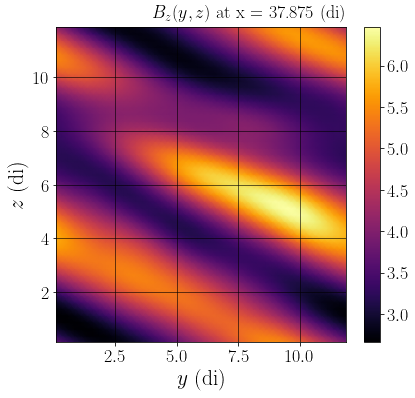

In [118]:
plt2d.make_field_pmesh(dfields,fieldkey,'yz',takeaxisaverage=False, xxindex=xxidx)
plt2d.make_field_pmesh(dfields,fieldkey,'yz',takeaxisaverage=False, xxindex=xxidx, flnm = 'm06_th45xpos'+str(xx)+'pmesh')

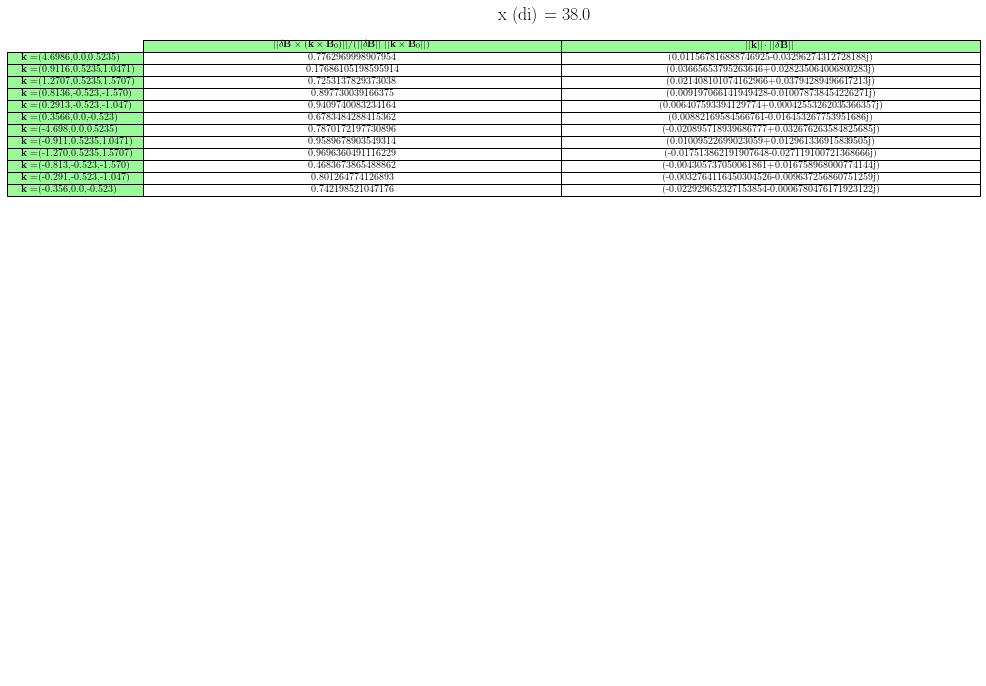

In [119]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

#test given k's
results, kxexpected = anl.alfven_wave_check(dfields,dfieldsfluc,klist,xx)

#build and make table
results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
#results_table = [[results[j][1]] for j in range(0,len(results))]
collbls = [r'$|| \delta \mathbf{B} \times (\mathbf{k} \times \mathbf{B}_0)|| / (|| \delta \mathbf{B} ||$ $||\mathbf{k} \times \mathbf{B}_0||)$',
          r'$||\mathbf{k}|| \cdot ||\delta \mathbf{B}||$']
rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
plttbl.make_table(rowlbls,collbls,results_table,ttl='x (di) = '+str(xx),flnm='m06_th45xpos'+str(xx)+'planewaveprops')
plttbl.make_table(rowlbls,collbls,results_table,ttl='x (di) = '+str(xx),flnm='')

In [ ]:
# dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

# #build list of k's to test
# klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

# #test given k's
# results, kxexpected = anl.alfven_wave_check(dfields,dfieldsfluc,klist,xx)

# #build and make table
# results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
# collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
#            r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
#            r'$|| \mathbf{k} || \cdot || \delta \mathbf{B} ||$']
# rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
# plttbl.make_table(rowlbls,collbls,results_table,ttl='x (di) = '+str(xx),flnm='m06_th45xpos'+str(xx)+'planewaveprops.png')
# plttbl.make_table(rowlbls,collbls,results_table,ttl='x (di) = '+str(xx),flnm='')

In [ ]:
# dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

# dfieldsavg = anl.get_average_fields_over_yz(dfieldsfluc)

# #build list of k's to test
# klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

# #test given k's
# results = anl.alfven_wave_check(dfieldsavg,klist,xx)

# #build and make table
# results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
# collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
#            r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
#            r'$|| \delta \mathbf{B} || \cdot || \mathbf{k} ||$']
# rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
# plttbl.make_table(rowlbls,collbls,results_table,ttl='',flnm='')

### See what kx needs to be given some ky, kz

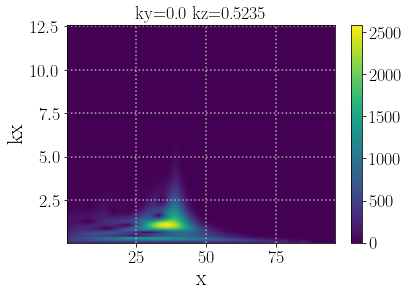

In [1228]:
#TODO: generate plots related to the true part here
i = 0
pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', xlim = None, ylim = None)

first val
(-1.9706417285620215-0.14321387748958073j)
minval, xxidx
(-0.07817247343401446-0.36445929303524627j) 0
first val
(-0.9021285796479861+0.03972533999817472j)
minval, xxidx
(-0.24905292589882078+0.09039644509625626j) 1
first val
(-0.9044876923162255+0.03937199819012916j)
minval, xxidx
(-0.2896134422468244+0.005368792901246491j) 2
first val
(-0.9085001466379631+0.037312273827696044j)
minval, xxidx
(-0.29418253902542035+0.09792692554899848j) 3
first val
(-0.9136320734517359+0.03409080680027367j)
minval, xxidx
(-0.32760669102505724-0.041070867836906756j) 4
first val
(-0.9197871219288564+0.029812272859924695j)
minval, xxidx
(-0.2691591882527612-0.046330249993122276j) 5
first val
(-0.9274963856994424+0.02398394113504493j)
minval, xxidx
(-0.11243238395265953-0.04234550350507543j) 6
first val
(-1.3261046000555101+0.10817622337023111j)
minval, xxidx
(-0.18999732827467464+0.019599635213947666j) 7
first val
(-1.67848318819067-0.18228740391096682j)
minval, xxidx
(-0.07592058073416974-0.009

first val
(-0.8682886596353525-0.2805053420627771j)
minval, xxidx
(-0.6132223729581545+0.06739846694813885j) 73
first val
(-0.8857231371042822-0.26712052413855525j)
minval, xxidx
(-0.5964387582271928-0.00467453440190118j) 74
first val
(-0.877936174104771-0.2548895086266187j)
minval, xxidx
(-0.5990105041344658+0.03436502810552267j) 75
first val
(-0.8801909793051197-0.2340256443048447j)
minval, xxidx
(-0.6141835960122897-0.09904719033997142j) 76
first val
(-0.8394187668001452-0.21757895864904578j)
minval, xxidx
(-0.6275777752307226-0.02201208655400795j) 77
first val
(-0.8599200148271353-0.20386727556701867j)
minval, xxidx
(-0.6617538165957794+0.059749818111309166j) 78
first val
(-0.8477989920574036-0.18968075718547708j)
minval, xxidx
(-0.5885337771964694-0.21956219906455834j) 79
first val
(-0.8677234911779061-0.17892238682551975j)
minval, xxidx
(-0.4706172972193261-0.1413657439936415j) 80
first val
(-0.8464120302477436-0.16583324004121308j)
minval, xxidx
(-0.3967743157808099+0.0137898103

first val
(-0.6753116236492728-0.08458393631328062j)
minval, xxidx
(-0.6753116236492728-0.08458393631328062j) 146
first val
(-0.756391312601907-0.03200757625509669j)
minval, xxidx
(-0.756391312601907-0.03200757625509669j) 147
first val
(-0.8972541502845363+0.05860575804349193j)
minval, xxidx
(-0.8972541502845363+0.05860575804349193j) 148
first val
(-1.0982941629559373+0.1832620141562085j)
minval, xxidx
(-0.8926583150332249+0.01675817872196452j) 149
first val
(-1.281952107977604+0.27912761205467324j)
minval, xxidx
(-0.773376218210895+0.016411134271037128j) 150
first val
(-1.3634326157723236+0.31328757070328367j)
minval, xxidx
(-0.7633071921257538+0.055340789793554473j) 151
first val
(-1.2866334535106874+0.28614746676118397j)
minval, xxidx
(-0.8449142642911918-0.06884143264427021j) 152
first val
(-0.9416527001819999+0.061267652667803776j)
minval, xxidx
(-0.3656277407441505+0.0990381667677052j) 153
first val
(-0.6659983148267805-0.11609555509586167j)
minval, xxidx
(-0.6659983148267805-0.1

first val
(-0.1061773028740407+0.405295997641146j)
minval, xxidx
(-0.17905297301915635-0.13353668120224446j) 217
first val
(-0.11238669047906313+0.4194886166201928j)
minval, xxidx
(-0.17221876124694124-0.07599015485494712j) 218
first val
(-0.11904722737363826+0.4341032039765287j)
minval, xxidx
(-0.1693825177980468-0.018121983786718487j) 219
first val
(-0.1261361058176349+0.449033357875486j)
minval, xxidx
(-0.10252330304309865+0.022253936218606604j) 220
first val
(-0.13356337225164494+0.4640562668397104j)
minval, xxidx
(-0.17574885235782+0.09740287149835505j) 221
first val
(-0.1411897309439598+0.4788881427566616j)
minval, xxidx
(-0.00764738513996166-0.01647520907171927j) 222
first val
(-0.14885901555953684+0.49325464499153937j)
minval, xxidx
(-0.12687826150754655+0.050844557527101764j) 223
first val
(-0.15643152519459824+0.5069487987696085j)
minval, xxidx
(-0.03150943640707615-0.03987637048814714j) 224
first val
(-0.1638064571743041+0.5198586487375522j)
minval, xxidx
(-0.049721055279566

first val
(-1.2424352696939391+0.9469995957421886j)
minval, xxidx
(-0.16961429557952434+0.05573960635363792j) 290
first val
(-1.2785271588798404+0.9342104555658048j)
minval, xxidx
(-0.21109514389731177+0.17155137382087657j) 291
first val
(-1.314819843886958+0.919582855713969j)
minval, xxidx
(-0.2808615404902842-0.10847661483313799j) 292
first val
(-1.3509689773660747+0.9031652832497206j)
minval, xxidx
(-0.2773537372764907-0.06039426455558396j) 293
first val
(-1.3865108829088686+0.8851007661700201j)
minval, xxidx
(-0.09393109203634831-0.23744807423301775j) 294
first val
(-1.4209270039056476+0.865628814818928j)
minval, xxidx
(-0.08566217002707499-0.1922053447133542j) 295
first val
(-1.45374839095556+0.8450532878980715j)
minval, xxidx
(-0.0471004038475199-0.03417976554057075j) 296
first val
(-1.4846524124314116+0.8236847086833458j)
minval, xxidx
(-0.07606837313813486-0.10035628692010302j) 297
first val
(-1.5135102248418428+0.8017813356151748j)
minval, xxidx
(-0.0748169372784494-0.05435263

first val
(-0.3038683545172721-0.009318238100861643j)
minval, xxidx
(-0.3038683545172721-0.009318238100861643j) 363
first val
(-0.3398922279905422+0.07994641694309537j)
minval, xxidx
(-0.23979797163017735-0.19231492687950094j) 364
first val
(-0.3743376784027358+0.14437505025205674j)
minval, xxidx
(-0.08163986391511957-0.09352482103569305j) 365
first val
(-0.4051567850179054+0.18944938287876315j)
minval, xxidx
(-0.0150953983605977-0.004799559561591154j) 366
first val
(-0.4323478749783588+0.2205671899735854j)
minval, xxidx
(-0.0733542116105923-0.028473781627372415j) 367
first val
(-0.4565636458775326+0.24214148598439006j)
minval, xxidx
(-0.2845314952459176+0.07142504155649086j) 368
first val
(-0.4785030972011869+0.2575384618717864j)
minval, xxidx
(-0.300772050955067+0.11417195109118485j) 369
first val
(-0.498707212266548+0.26920059696464804j)
minval, xxidx
(-0.31847988369578795+0.1526296683261644j) 370
first val
(-0.5175370813288326+0.27878106408010134j)
minval, xxidx
(-0.029800798493982

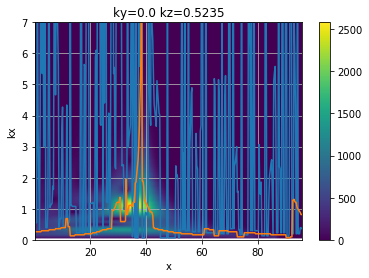

first val
(-0.8989372166225733-0.349355491617804j)
minval, xxidx
(-0.7495102287909292-0.035674516735534054j) 0
first val
(-1.8713027444629518-0.14519905961276935j)
minval, xxidx
(-0.10186624794376642-0.08771613386110644j) 1
first val
(-1.868104272268103-0.1590617869798549j)
minval, xxidx
(-0.10605616496279158+0.08010861075377185j) 2
first val
(-1.8644717044125176-0.17276607526167817j)
minval, xxidx
(-0.06963361683562885-0.05426437154168028j) 3
first val
(-1.8616473825542577-0.18637245763017812j)
minval, xxidx
(-0.08123248848065479+0.0006621351656667801j) 4
first val
(-1.8588077629365192-0.19993594331837394j)
minval, xxidx
(-0.12311016766874228-0.10767790825374396j) 5
first val
(-1.8546840944415646-0.21340545665908914j)
minval, xxidx
(-0.061320056201236484-0.05076042694314904j) 6
first val
(-1.8474355786157974-0.22639626506423696j)
minval, xxidx
(-0.033221818424028604-0.010569710296383792j) 7
first val
(-1.8328711599711611-0.23764877724092134j)
minval, xxidx
(-0.059035799590645865-0.006

first val
(-0.1979521185863472-0.025121130164479248j)
minval, xxidx
(-0.1979521185863472-0.025121130164479248j) 73
first val
(-0.19238869723169294-0.011820213936981412j)
minval, xxidx
(-0.19238869723169294-0.011820213936981412j) 74
first val
(-0.18808381071738467+0.0014984608776384203j)
minval, xxidx
(-0.18808381071738467+0.0014984608776384203j) 75
first val
(-0.18519396406573785+0.014748423653900562j)
minval, xxidx
(-0.18519396406573785+0.014748423653900562j) 76
first val
(-0.1837815485145794+0.027850772747047843j)
minval, xxidx
(-0.1837815485145794+0.027850772747047843j) 77
first val
(-0.18387736030965196+0.040729940205816724j)
minval, xxidx
(-0.18387736030965196+0.040729940205816724j) 78
first val
(-0.18541337579502815+0.053332348587347096j)
minval, xxidx
(-0.18541337579502815+0.053332348587347096j) 79
first val
(-0.18809509023902582+0.06566583629350614j)
minval, xxidx
(-0.17549802655983082+0.0438263241273296j) 80
first val
(-0.19134887651292276+0.07783078745162969j)
minval, xxidx
(

first val
(-0.5042113643426507-0.40653784890421485j)
minval, xxidx
(-0.4781461429944691-0.12097249431531486j) 145
first val
(-0.6586068681355834+0.6792031054331931j)
minval, xxidx
(-0.12460926522318949-0.006307888554826153j) 146
first val
(-0.6596771506402752+0.7180880806461654j)
minval, xxidx
(-0.21323829144095519+0.16602084709674275j) 147
first val
(-0.6604716299767779+0.765465377897637j)
minval, xxidx
(-0.22083172937088547-0.13452265547437917j) 148
first val
(-0.6652248570220718+0.8063290328534114j)
minval, xxidx
(-0.23301984487059013+0.015365254178077558j) 149
first val
(-0.6741276523216462+0.8357466284792864j)
minval, xxidx
(-0.35554330522644007-0.08092683057865971j) 150
first val
(-0.685744092672354+0.8548418139431412j)
minval, xxidx
(-0.3258160051592224-0.02420271726572795j) 151
first val
(-0.6987925359577299+0.8655385976070793j)
minval, xxidx
(-0.1946430408545533-0.10741321298183269j) 152
first val
(-0.7125569622380655+0.8680476983977371j)
minval, xxidx
(-0.43108577095890166-0.

first val
(-1.1249259054749154+0.2987790786585703j)
minval, xxidx
(-0.4593388831028927+0.06524620672747244j) 217
first val
(-1.1233875564288525+0.2929260170073701j)
minval, xxidx
(-0.5922454943983526+0.04985666377385972j) 218
first val
(-1.1223965905413715+0.2869841671543867j)
minval, xxidx
(-0.6217570227633276+0.21652149802863713j) 219
first val
(-1.1223756926180437+0.2812892841924501j)
minval, xxidx
(-0.33491847277527853-0.23114195051405903j) 220
first val
(-1.123563935854709+0.276060835076013j)
minval, xxidx
(-0.17066706240161444+0.017878122817363076j) 221
first val
(-1.1259506852716499+0.271404531543414j)
minval, xxidx
(-0.33037066349862765+0.16722447738587978j) 222
first val
(-1.1292957521249198+0.2673449312332133j)
minval, xxidx
(-0.8373429672848542+0.01087907898283888j) 223
first val
(-1.1332207483059775+0.26386730519487706j)
minval, xxidx
(-0.8384647944458976+0.02196329747797318j) 224
first val
(-1.137326902233156+0.26094628806832065j)
minval, xxidx
(-0.6982167085109507-0.17829

first val
(-1.3235930552670458+0.23971849993125474j)
minval, xxidx
(-0.3473720230973636-0.01842765162577841j) 289
first val
(-1.3296390028430862+0.23914329078331217j)
minval, xxidx
(-0.5875902243668134+0.13924132547640677j) 290
first val
(-1.3368366175864885+0.23290513280423328j)
minval, xxidx
(-0.5917326188595793+0.1574020370376162j) 291
first val
(-1.3445260671490336+0.22089424923855364j)
minval, xxidx
(-0.6022582381456295+0.1761475884213518j) 292
first val
(-1.3517607672696774+0.20348149112771693j)
minval, xxidx
(-0.619019786081429+0.19430100233881578j) 293
first val
(-1.357421944456013+0.18142183804761203j)
minval, xxidx
(-0.6413546932966536+0.21046246816187564j) 294
first val
(-1.3604439393402883+0.1557368339102262j)
minval, xxidx
(-0.6288323674974058+0.030750109411383997j) 295
first val
(-1.3601184573005514+0.12756604218957804j)
minval, xxidx
(-0.48796885906950604-0.2546154405481349j) 296
first val
(-1.3563743854205497+0.09800133362105368j)
minval, xxidx
(-0.43636517953683107-0.0

first val
(-0.8859992114456443+0.20892697256571283j)
minval, xxidx
(-0.711694121895736-0.11727057358384596j) 361
first val
(-0.8929318096536824+0.2068045048397971j)
minval, xxidx
(-0.654280786858112-0.023324298987881242j) 362
first val
(-0.9005355814278712+0.20533140914896622j)
minval, xxidx
(-0.6558431267922546+0.005237303727517573j) 363
first val
(-0.9084209677405733+0.20605251253828272j)
minval, xxidx
(-0.6697957143528805+0.02128059693658052j) 364
first val
(-0.9166803010691611+0.20929591416522j)
minval, xxidx
(-0.1522508140028459-0.1698795051921056j) 365
first val
(-0.925525971876858+0.21441919575786644j)
minval, xxidx
(-0.02111898787626698-0.013167644784956713j) 366
first val
(-0.9349759589325123+0.22023787064180128j)
minval, xxidx
(-0.09318358793705217+0.001997859324991641j) 367
first val
(-0.9448728806881405+0.22549934158835583j)
minval, xxidx
(-0.07654843406824852+0.2925271345107552j) 368
first val
(-0.9550869744131669+0.22925534014466725j)
minval, xxidx
(-0.562880603831388+0.2

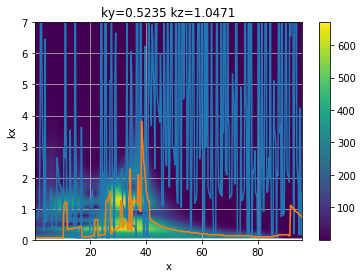

first val
(-1.4768443694420479-0.41147686987851706j)
minval, xxidx
(-0.14865796063762815-0.01890991745745589j) 0
first val
(-1.1103855318959108+0.028063379321558446j)
minval, xxidx
(-0.1422884223367311-0.253211185216885j) 1
first val
(-1.0854746547703682+0.04241479594268607j)
minval, xxidx
(-0.11229601397737987+0.031561468300554396j) 2
first val
(-1.0474498981841525+0.06549720691074952j)
minval, xxidx
(-0.31797670828133184+0.03911576490296854j) 3
first val
(-1.0330158858274028+0.08103399820773473j)
minval, xxidx
(-0.1067729398596583+0.13945056589860716j) 4
first val
(-1.024800545962683+0.09319135118759135j)
minval, xxidx
(-0.4893090687549324-0.019253687912921764j) 5
first val
(-0.9970493700560179+0.11529636355743961j)
minval, xxidx
(-0.3892409624974582+0.0008069246258985766j) 6
first val
(-0.945440194282024+0.14925010961406002j)
minval, xxidx
(-0.4188605107506911+0.0885911528679641j) 7
first val
(-0.8865324292886044+0.19549333622052545j)
minval, xxidx
(-0.26636582971750056+0.0818000990

first val
(-0.8028068959698174-0.38450831648516676j)
minval, xxidx
(-0.3692534587078119+0.13162599626853178j) 73
first val
(-0.7938905083440535-0.39340300222301094j)
minval, xxidx
(-0.49805361212773414-0.04724480874363424j) 74
first val
(-0.7851146125181427-0.4003259785708153j)
minval, xxidx
(-0.3909552473671698-0.22936485064645717j) 75
first val
(-0.7766603050848275-0.40493589501757266j)
minval, xxidx
(-0.37103866409256114-0.17880502101969598j) 76
first val
(-0.7687052461935673-0.40698604174214814j)
minval, xxidx
(-0.3576768054765982-0.12656931538631966j) 77
first val
(-0.7614301112412104-0.40628678898648396j)
minval, xxidx
(-0.3508668081553602-0.07357836772829965j) 78
first val
(-0.7549475649737574-0.40292128743824385j)
minval, xxidx
(-0.3002231987621621-0.15389105798164304j) 79
first val
(-0.7491872184280701-0.3975151575606498j)
minval, xxidx
(-0.2948673812527344-0.09124726396968406j) 80
first val
(-0.7438273051099697-0.39127772204759215j)
minval, xxidx
(-0.2956687247818899-0.028897

first val
(-1.404299056852503+0.2066583268132839j)
minval, xxidx
(-0.4886490267152447-0.15344731410987794j) 146
first val
(-0.5634252215611869+0.02754209014914591j)
minval, xxidx
(-0.21464890010501803+0.036856368029507106j) 147
first val
(-0.46706746181754766+0.017283051257170848j)
minval, xxidx
(-0.019308586962128782-0.083477045714066j) 148
first val
(-0.39030528982235657+0.011346684449064587j)
minval, xxidx
(-0.18427740025350747+0.04386041881845724j) 149
first val
(-0.3409753857817701+0.011282567016335843j)
minval, xxidx
(-0.007690167303791684-0.017454653572584605j) 150
first val
(-0.31449952242655743+0.016347916386258113j)
minval, xxidx
(-0.012513617690824819-0.006791041830636184j) 151
first val
(-0.3065551129694065+0.025573336354769605j)
minval, xxidx
(-0.13482345023151632+0.09076881740722764j) 152
first val
(-0.3184155577623944+0.0385865755041258j)
minval, xxidx
(-0.1638500845861417-0.08545356435756676j) 153
first val
(-0.36307799816397923+0.05575991063913958j)
minval, xxidx
(-0.1

first val
(-0.6512326165046014+0.5441183017753369j)
minval, xxidx
(-0.20800844818929543-0.08951283386768866j) 218
first val
(-0.6606549751031012+0.5517877893379664j)
minval, xxidx
(-0.06745778300056426-0.027693430697760743j) 219
first val
(-0.6687082101687752+0.5589277728645987j)
minval, xxidx
(-0.18842355297434377+0.02042405133184828j) 220
first val
(-0.674742341209331+0.5655803482013161j)
minval, xxidx
(-0.11512385044369067+0.003916535456135977j) 221
first val
(-0.6783292314302213+0.5719358446515176j)
minval, xxidx
(-0.14019799677601963-0.14281465938415153j) 222
first val
(-0.679321121910596+0.5782070015082362j)
minval, xxidx
(-0.15497765661118468+0.14158298418246543j) 223
first val
(-0.6778335293603883+0.5845254016221073j)
minval, xxidx
(-0.3132680477806763+0.15533083585561341j) 224
first val
(-0.674176589002073+0.5909104180801821j)
minval, xxidx
(-0.23966436809536873-0.06351388039796413j) 225
first val
(-0.6687758823535894+0.5973021511516876j)
minval, xxidx
(-0.2779494078874495-0.0

first val
(-1.1110185390135867+0.21092061159407957j)
minval, xxidx
(-0.12995579235613064+0.029493278428241426j) 290
first val
(-1.1334782837775443+0.1990777219802849j)
minval, xxidx
(-0.2023386334295798-0.16169764739954684j) 291
first val
(-1.1555584173455076+0.19062400129710788j)
minval, xxidx
(-0.19576707509703428-0.029347695082585806j) 292
first val
(-1.1762295721583707+0.1860001419873914j)
minval, xxidx
(-0.21164052238305886+0.09901749743769458j) 293
first val
(-1.194725708213606+0.18522794704486517j)
minval, xxidx
(-0.12497708082617853-0.18931715443963404j) 294
first val
(-1.2107524255905489+0.1879592274159257j)
minval, xxidx
(-0.10934941465185322-0.04530707460364135j) 295
first val
(-1.2245194612467591+0.1936718667279961j)
minval, xxidx
(-0.0848249783052697+0.011738204895337556j) 296
first val
(-1.236611474690551+0.20191390551304303j)
minval, xxidx
(-0.1538906379853331-0.06869012742748598j) 297
first val
(-1.2477748380332994+0.21245704234188145j)
minval, xxidx
(-0.155522553449765

first val
(-1.1947625078612218+0.13496039829755643j)
minval, xxidx
(-0.040824410163517344+0.053449912612086405j) 362
first val
(-1.097591126080028+0.14555599532139654j)
minval, xxidx
(-0.18489452495087855+0.04994152904658221j) 363
first val
(-1.0200450697594363+0.15343030833427684j)
minval, xxidx
(-0.25062257682360134+0.1916080974110429j) 364
first val
(-0.9604634231898689+0.15882606904261062j)
minval, xxidx
(-0.367195673865902+0.21990268332052965j) 365
first val
(-0.915930530266861+0.1622183937975801j)
minval, xxidx
(-0.4079001778144641-0.27135477535268093j) 366
first val
(-0.8831506523998578+0.16371631245982549j)
minval, xxidx
(-0.365798709771183-0.12358738456052448j) 367
first val
(-0.8592394202580405+0.16327638724262988j)
minval, xxidx
(-0.2738561274935676-0.09888798258837264j) 368
first val
(-0.8422024931440344+0.16111462376886157j)
minval, xxidx
(-0.11577719686682397-0.04155657445712813j) 369
first val
(-0.831033572000002+0.15781882542509912j)
minval, xxidx
(-0.1762516581285013+0

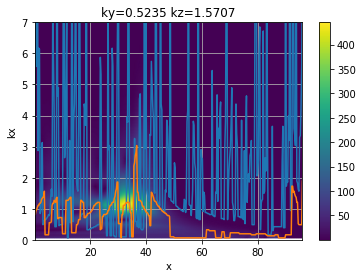

first val
(-1.3886526945440574+0.4789369987504175j)
minval, xxidx
(-0.0730397653878554-0.021601591835921738j) 0
first val
(-0.18345188112604094+0.12994817878317086j)
minval, xxidx
(-0.1058042796724471-0.09041045497707965j) 1
first val
(-0.17212219127017014+0.14559550446708844j)
minval, xxidx
(-0.11632670609881013+0.06974396736445915j) 2
first val
(-0.15724442428907714+0.16253623959601415j)
minval, xxidx
(-0.08624184857475448-0.06202555591846368j) 3
first val
(-0.14671420686329295+0.1790453163893595j)
minval, xxidx
(-0.0665148542893681-0.044053871368931824j) 4
first val
(-0.1378407143184912+0.19561176963522145j)
minval, xxidx
(-0.07111587218317494+0.023219315165944186j) 5
first val
(-0.1263512155051325+0.2134017203216586j)
minval, xxidx
(-0.054071160869786916-0.04661992219873538j) 6
first val
(-0.11136373627359708+0.23295382909457604j)
minval, xxidx
(-0.016817692207978352-0.009227126572882386j) 7
first val
(-0.0969431042757044+0.2534574359677116j)
minval, xxidx
(-0.07140815979146109-0.0

first val
(-1.1287881292326383+0.22333122153012466j)
minval, xxidx
(-0.1858397516686554-0.028867130360875494j) 73
first val
(-1.1290986078208964+0.2184638432440625j)
minval, xxidx
(-0.3981549398974775+0.48226352754615676j) 74
first val
(-1.1296581177159744+0.21392262090859576j)
minval, xxidx
(-0.5760233331160909+0.679087934931055j) 75
first val
(-1.1306080776540686+0.2098086226506026j)
minval, xxidx
(-0.6657852322423087+0.6797144368102782j) 76
first val
(-1.1320908555929141+0.20621008440369595j)
minval, xxidx
(-0.7045869365094284+0.699892406507117j) 77
first val
(-1.1342414136008019+0.2031971254403502j)
minval, xxidx
(-0.36989421886724116-0.2731302266448329j) 78
first val
(-1.137101464622196+0.20075719544186676j)
minval, xxidx
(-0.29146328742673344+0.013385091200136354j) 79
first val
(-1.1405211924214613+0.19873119951466822j)
minval, xxidx
(-0.46022647783222537+0.07538867452598359j) 80
first val
(-1.1441446177582326+0.19682369219087248j)
minval, xxidx
(-0.49227725770846886-0.2514762477

first val
(-1.281283354045529-0.03958549362024631j)
minval, xxidx
(-0.01517544468588572+0.00443984173038656j) 146
first val
(-1.2571794575908122-0.03345034807226919j)
minval, xxidx
(-0.013280595918503058-0.00458228985453827j) 147
first val
(-1.222527227656831-0.022846844801939256j)
minval, xxidx
(-0.5664233502755559+0.02890898906943766j) 148
first val
(-1.187448073537912-0.01199576476879486j)
minval, xxidx
(-0.47719758779683197-0.2966378137337103j) 149
first val
(-1.1605773720471952-0.004082970935084279j)
minval, xxidx
(-0.13670358704853125-0.041738000570933895j) 150
first val
(-1.145463974771478-0.0004523248521995857j)
minval, xxidx
(-0.15771424731519024+0.029405294728573516j) 151
first val
(-1.1430957209812398-0.0018069044479882418j)
minval, xxidx
(-0.32754496627698415+0.0679816610168862j) 152
first val
(-1.1550147596605713-0.009489556375443714j)
minval, xxidx
(-0.4204440843781917-0.14170050575312337j) 153
first val
(-1.1849583677867366-0.026507303785436434j)
minval, xxidx
(-0.434228

first val
(-0.49575450396935095-0.3627588462955699j)
minval, xxidx
(-0.26486620343347156+0.067645967687914j) 218
first val
(-0.49266652997923255-0.3563753028059172j)
minval, xxidx
(-0.3856514665104297+0.01030187183317273j) 219
first val
(-0.4899708248416337-0.35027535061436255j)
minval, xxidx
(-0.385288364588225+0.022954945593690393j) 220
first val
(-0.48756386992928125-0.3442846934476943j)
minval, xxidx
(-0.38522643624595176+0.03543567406989481j) 221
first val
(-0.48528906396280846-0.3382093063285267j)
minval, xxidx
(-0.38555306781606746+0.04783732987100663j) 222
first val
(-0.4829747649521021-0.3318786477565989j)
minval, xxidx
(-0.18111949886763434-0.0419520384576168j) 223
first val
(-0.48047451669161056-0.32517424229766495j)
minval, xxidx
(-0.24124228187511976+0.2119678480256897j) 224
first val
(-0.47770045500040736-0.31804115708680786j)
minval, xxidx
(-0.3894107529433316+0.08556616781567114j) 225
first val
(-0.47462783143746523-0.3104821946206076j)
minval, xxidx
(-0.391728102175437

first val
(-0.44895322570059126+0.23904325592258308j)
minval, xxidx
(-0.3816458951037439+0.19740105085668092j) 290
first val
(-0.45538864069886786+0.24954783121998939j)
minval, xxidx
(-0.39628448174008934+0.22898377083376684j) 291
first val
(-0.46222257715578163+0.2597898333411594j)
minval, xxidx
(-0.41261217436569375+0.2594445540788831j) 292
first val
(-0.46940832569033375+0.2696658195030603j)
minval, xxidx
(-0.04659698768034082-0.10410561943243442j) 293
first val
(-0.4768565748352678+0.27904708945159123j)
minval, xxidx
(-0.3433687507896971+0.08499114675390465j) 294
first val
(-0.484442602974439+0.2878025914891452j)
minval, xxidx
(-0.484442602974439+0.2878025914891452j) 295
first val
(-0.4920503601346138+0.29584776047725925j)
minval, xxidx
(-0.4920503601346138+0.29584776047725925j) 296
first val
(-0.4996317027089425+0.3032077349087575j)
minval, xxidx
(-0.20064808283785696-0.08381466211978846j) 297
first val
(-0.507244373706843+0.31006079140002185j)
minval, xxidx
(-0.034241755628608206

first val
(-1.52256380537492+0.41051103605518546j)
minval, xxidx
(-0.4733309988914557-0.049540645069639344j) 363
first val
(-1.552968483001746+0.3690718114454445j)
minval, xxidx
(-0.48123136002560507+0.024858843989463558j) 364
first val
(-1.5485606366186173+0.31225603203572305j)
minval, xxidx
(-0.4627466086146438-0.06654715367945103j) 365
first val
(-1.5110847771916827+0.25488104239391j)
minval, xxidx
(-0.4661081351961873+0.004579246327319597j) 366
first val
(-1.4583918641786953+0.211695259469778j)
minval, xxidx
(-0.2713880328385483-0.1554495329576212j) 367
first val
(-1.4076651206453434+0.18757154132717724j)
minval, xxidx
(-0.08339399371336131+0.0051257783089819105j) 368
first val
(-1.3680015860191663+0.17917178587926175j)
minval, xxidx
(-0.054580104954122244+0.013394038548254942j) 369
first val
(-1.3432813372959278+0.18008208559333966j)
minval, xxidx
(-0.34602992825255197+0.12638074181254794j) 370
first val
(-1.335094462321967+0.1838167751075094j)
minval, xxidx
(-0.37195323453063944-

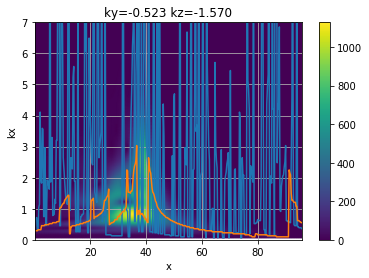

first val
(-1.317517942062958+0.46119166794852523j)
minval, xxidx
(-0.08791941392966995-0.02421326771469076j) 0
first val
(-0.12206222831895719+0.1454309526987683j)
minval, xxidx
(-0.17807180990981608-0.040055227738265045j) 1
first val
(-0.12306751845444774+0.15973442123703752j)
minval, xxidx
(-0.1593707047054138-0.009728306397440184j) 2
first val
(-0.12461780223908625+0.17397790089601178j)
minval, xxidx
(-0.11318612434786635-0.049889242162374565j) 3
first val
(-0.1272028802001619+0.18788117344709107j)
minval, xxidx
(-0.1445251497437844-0.005836374008889492j) 4
first val
(-0.13013324584241415+0.2016876823016978j)
minval, xxidx
(-0.15783929196638324-0.024077277752824026j) 5
first val
(-1.6161022510846355-0.27965762823779095j)
minval, xxidx
(-0.053709771937053064-0.04222292712932791j) 6
first val
(-1.6406613334012508-0.2880433988271194j)
minval, xxidx
(-0.04780930044327136+0.02920450319869535j) 7
first val
(-1.685160710220487-0.2953802687722796j)
minval, xxidx
(-0.04619089875784821+0.100

first val
(-1.1265013860013438+0.23773475839387812j)
minval, xxidx
(-0.1840778449153534-0.02945605754404555j) 73
first val
(-1.1272016335890367+0.2324320829568358j)
minval, xxidx
(-0.39667932757990443+0.4825290760248987j) 74
first val
(-1.1282223648338552+0.2276115135887189j)
minval, xxidx
(-0.5757133952947031+0.6888312042929378j) 75
first val
(-1.1297068002830666+0.2233805625305068j)
minval, xxidx
(-0.6385028868169541+0.7638069282355099j) 76
first val
(-1.131776935431423+0.21981066779082442j)
minval, xxidx
(-0.682470627377959+0.783250421433014j) 77
first val
(-1.134542058608067+0.216949960263707j)
minval, xxidx
(-0.36886692733148674-0.2745145397653733j) 78
first val
(-1.1380295288517854+0.2147639643012881j)
minval, xxidx
(-0.2894704001628885+0.012160109661794358j) 79
first val
(-1.14208969293718+0.21306316915759327j)
minval, xxidx
(-0.4579321286856486+0.07278374858117043j) 80
first val
(-1.1463685751433785+0.2115020177959795j)
minval, xxidx
(-0.5214688631629125-0.17150786533663048j) 8

first val
(-1.297721248976218-0.03188180453380376j)
minval, xxidx
(-0.014506035091078062+0.0040012391693260395j) 146
first val
(-1.271616761554505-0.027786420455176992j)
minval, xxidx
(-0.013554203307456492-0.0041365966670730905j) 147
first val
(-1.2348168396266657-0.01940668995267196j)
minval, xxidx
(-0.5432890425657753+0.024771398107215174j) 148
first val
(-1.1981237404738723-0.010291934421327364j)
minval, xxidx
(-0.45582972722836734-0.31810782566428064j) 149
first val
(-1.169658054960243-0.0032662713430281626j)
minval, xxidx
(-0.1367536743686063-0.041696960225955794j) 150
first val
(-1.1527375072078048+0.000261040233514441j)
minval, xxidx
(-0.15780810549885171+0.02946835939193398j) 151
first val
(-1.1482509975770974-0.0004810747402114457j)
minval, xxidx
(-0.3275301607794956+0.06794163668804822j) 152
first val
(-1.1573853654001756-0.006591453732289934j)
minval, xxidx
(-0.40086479776987227-0.1516249352296647j) 153
first val
(-1.183434408886706-0.02036033323971495j)
minval, xxidx
(-0.4

first val
(-0.5646240518112087-0.3686927407613934j)
minval, xxidx
(-0.2669058149268435+0.06610595955298935j) 218
first val
(-0.5615241077794898-0.3636688311310118j)
minval, xxidx
(-0.4340611289383596-0.032205760688251525j) 219
first val
(-0.5588690191299246-0.35891039408831366j)
minval, xxidx
(-0.43241701755585105-0.020801405003599824j) 220
first val
(-0.5565515996594362-0.35421046273354395j)
minval, xxidx
(-0.431077216339005-0.009588742989493776j) 221
first val
(-0.5544023757923768-0.3493509048446411j)
minval, xxidx
(-0.4301580351249391+0.0015346167028395807j) 222
first val
(-0.5522347297766113-0.344149664601837j)
minval, xxidx
(-0.18025146150804938-0.03732905655426215j) 223
first val
(-0.549890367234679-0.3384889401620342j)
minval, xxidx
(-0.24095520253443892+0.21147003369802897j) 224
first val
(-0.5472743935686732-0.3323228518766992j)
minval, xxidx
(-0.43059589048465063+0.035458961569637244j) 225
first val
(-0.5443535261928257-0.3256670090869846j)
minval, xxidx
(-0.4318747269856019+

first val
(-0.47167134499176433+0.16955112218556678j)
minval, xxidx
(-0.41621441546640514+0.1702293129284965j) 290
first val
(-0.47745768872411587+0.17953768875163195j)
minval, xxidx
(-0.4293405209401018+0.1997437283331273j) 291
first val
(-0.48362948442371734+0.1893359119645736j)
minval, xxidx
(-0.44407490327029997+0.2282232029097614j) 292
first val
(-0.49010948349876216+0.19884900476079348j)
minval, xxidx
(-0.04496742686854649-0.10363362451144752j) 293
first val
(-0.49678099857403835+0.20794520188021365j)
minval, xxidx
(-0.3450388346242017+0.08622070196270099j) 294
first val
(-0.503501750869259+0.21647993866023774j)
minval, xxidx
(-0.503501750869259+0.21647993866023774j) 295
first val
(-0.5101534173506633+0.22434484071463617j)
minval, xxidx
(-0.5101534173506633+0.22434484071463617j) 296
first val
(-0.5167021804170238+0.2315360185198332j)
minval, xxidx
(-0.19645541611533057-0.08587149679143469j) 297
first val
(-0.5232352087424349+0.23820579428384325j)
minval, xxidx
(-0.033381452720862

first val
(-1.4503790376770227+0.3148123831113304j)
minval, xxidx
(-0.4764332156755712-0.09710221636284708j) 362
first val
(-1.514190058780385+0.288790255500334j)
minval, xxidx
(-0.47767426484883546-0.021106315180859023j) 363
first val
(-1.5633728913146139+0.24555488097931605j)
minval, xxidx
(-0.47881751059025923-0.11096667025900968j) 364
first val
(-1.5806810379561758+0.19180504538413146j)
minval, xxidx
(-0.476346223052019-0.04049740452504301j) 365
first val
(-1.5634518938393316+0.14232049939311006j)
minval, xxidx
(-0.4833052823418327+0.02862146834131464j) 366
first val
(-1.5266221551727706+0.1091441502402811j)
minval, xxidx
(-0.2660732387624076-0.15851457788304785j) 367
first val
(-1.4871664784278646+0.0946450617835247j)
minval, xxidx
(-0.08095211180516959+0.0038572240595624377j) 368
first val
(-1.4551716639799377+0.09455697541486238j)
minval, xxidx
(-0.05500188879554779+0.013347434812682996j) 369
first val
(-1.4355374115149926+0.10255107700625563j)
minval, xxidx
(-0.3207407767870691

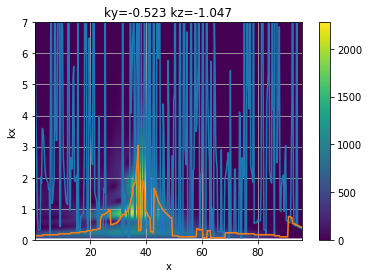

first val
(-0.029361952889235043+0.14321306023881655j)
minval, xxidx
(-0.029361952889235043+0.14321306023881655j) 0
first val
(-0.7671719703209818+0.1834340626373771j)
minval, xxidx
(-0.1481681943515042-0.2513072009350596j) 1
first val
(-0.7785753140412317+0.18613483512281592j)
minval, xxidx
(-0.11827908752326832+0.03149161607617037j) 2
first val
(-0.8177585786430508+0.18545274021755756j)
minval, xxidx
(-0.3434022696148653+0.05926429970612472j) 3
first val
(-0.8350628754715067+0.1800352605319578j)
minval, xxidx
(-0.11502498600604716+0.13816225684899713j) 4
first val
(-0.8325935488849535+0.1729251683429876j)
minval, xxidx
(-0.5423233445679787+0.024371878779404013j) 5
first val
(-0.8689916896528664+0.16303883813708558j)
minval, xxidx
(-0.39018089423593305+0.015636016527320912j) 6
first val
(-0.9053381225371642+0.14782197752358683j)
minval, xxidx
(-0.4220683356587295+0.09915485996463988j) 7
first val
(-0.9795398739959843+0.11937117265642355j)
minval, xxidx
(-0.7149252276263185-0.247464484

first val
(-1.09186159329985+0.018955040504680838j)
minval, xxidx
(-0.7439141837461303+0.03998010538283285j) 73
first val
(-1.0838131947920342+0.008902604450198715j)
minval, xxidx
(-0.5989935292197741-0.0059804482876979065j) 74
first val
(-1.089272537614254-0.002489919774280835j)
minval, xxidx
(-0.6013382756694169+0.032886715450763084j) 75
first val
(-1.0849660165460635-0.012545922608724183j)
minval, xxidx
(-0.6180523977670458-0.10058882433619529j) 76
first val
(-1.1036696534782515-0.024768324090775652j)
minval, xxidx
(-0.6303755110375064-0.022538701802325842j) 77
first val
(-1.093197555277546-0.03158273237186558j)
minval, xxidx
(-0.6751881374086754-0.21676218041667825j) 78
first val
(-1.0972159775745183-0.03825026318205032j)
minval, xxidx
(-0.5749652019726248-0.19845901159862922j) 79
first val
(-1.0855948703346952-0.04078454397126202j)
minval, xxidx
(-0.458409170784873-0.13155055969124999j) 80
first val
(-1.0913130172926513-0.04499732172580222j)
minval, xxidx
(-0.381566873266725+0.029

first val
(-1.1023211487283668-0.019020984789331646j)
minval, xxidx
(-0.8533060494418803-0.02753065846651753j) 146
first val
(-1.0334958870824704-0.06819317111615905j)
minval, xxidx
(-0.8094855201322484+0.029743111483056195j) 147
first val
(-0.9461650067986093-0.13540062190854305j)
minval, xxidx
(-0.9180741740905309-0.00817933586938596j) 148
first val
(-0.8618359250713853-0.20240137234976566j)
minval, xxidx
(-0.8631935715548744-0.05047393843910533j) 149
first val
(-0.8081105827909212-0.242633677969383j)
minval, xxidx
(-0.7733223187067348+0.017783457270088267j) 150
first val
(-0.7880216909140206-0.2534761097583363j)
minval, xxidx
(-0.7634567813210956+0.05724770558310888j) 151
first val
(-0.806763845265535-0.23730831198110738j)
minval, xxidx
(-0.8311066192482075-0.03921747878256032j) 152
first val
(-0.864217080463747-0.17883635144248547j)
minval, xxidx
(-0.36565381634581917+0.09903409584602013j) 153
first val
(-0.9667970646499718-0.09046488371134662j)
minval, xxidx
(-0.7589550643067076-0

first val
(-1.8875532476303842-0.41945929598877796j)
minval, xxidx
(-0.039993274883221575-0.12892272631348334j) 218
first val
(-1.880867609003943-0.4340612644179156j)
minval, xxidx
(-0.03570804047591558-0.09024339560999056j) 219
first val
(-1.8737554338627027-0.4489794777707045j)
minval, xxidx
(-0.03300916281703292-0.05141630090275425j) 220
first val
(-1.8663072757005028-0.46399140496103736j)
minval, xxidx
(-0.031896535221152655-0.012405036824851333j) 221
first val
(-1.858662925672963-0.47881350496765096j)
minval, xxidx
(-0.007750459448796376-0.016499323760547035j) 222
first val
(-1.850978974680245-0.4931716707988144j)
minval, xxidx
(-0.03447214185098402+0.06622697940243527j) 223
first val
(-1.843395365981725-0.5068590614027568j)
minval, xxidx
(-0.03128111140462175-0.03966691086042295j) 224
first val
(-1.8360127897697092-0.5197636278858676j)
minval, xxidx
(-0.049351857444149494-0.032347572085231445j) 225
first val
(-1.828885651699971-0.5318636154252449j)
minval, xxidx
(-0.0505716642241

first val
(-0.7232623129212792-0.9337060298335235j)
minval, xxidx
(-0.03031510144808136+0.05757180549077686j) 291
first val
(-0.6871432144749341-0.9190306081421912j)
minval, xxidx
(-0.03619087963536671+0.09783493102419938j) 292
first val
(-0.6511754185202916-0.9025572805998253j)
minval, xxidx
(-0.04407357172445425+0.13861047711656443j) 293
first val
(-0.6158192941309659-0.8844291543950402j)
minval, xxidx
(-0.05398390767629779+0.1794548360214309j) 294
first val
(-0.581588658477844-0.8648872820994524j)
minval, xxidx
(-0.06585582956567582+0.21983580184967816j) 295
first val
(-0.5489476402435698-0.8442381824322942j)
minval, xxidx
(-0.0480484294050586-0.03483082166737212j) 296
first val
(-0.5182156337411685-0.822795484588485j)
minval, xxidx
(-0.09483308586565753+0.2972655706556982j) 297
first val
(-0.4895210386359824-0.8008202176052247j)
minval, xxidx
(-0.11153357151435161+0.3337043891139161j) 298
first val
(-0.4628174261650847-0.7784831808942555j)
minval, xxidx
(-0.25819825997390944-0.1134

first val
(-1.6963838208097313+0.007964324567299634j)
minval, xxidx
(-0.49194445375525575-0.20088813566568897j) 363
first val
(-1.66039013131287-0.08124809041223859j)
minval, xxidx
(-0.5014895908189123-0.1394230577912876j) 364
first val
(-1.6259717051756442-0.14565106050561516j)
minval, xxidx
(-0.08133557966258109-0.09393552411587532j) 365
first val
(-1.5951735115500703-0.19072102821885148j)
minval, xxidx
(-0.01494268028593082-0.004895419879801731j) 366
first val
(-1.5679934323166607-0.22184466640070666j)
minval, xxidx
(-0.0729944041462327-0.028429415053198664j) 367
first val
(-1.5437749005810553-0.24341850123015188j)
minval, xxidx
(-0.5358685317863734-0.004815939827273722j) 368
first val
(-1.521816177692724-0.25878906754695824j)
minval, xxidx
(-0.5436334624103158+0.012637270919149249j) 369
first val
(-1.5015758884857164-0.2703803778783409j)
minval, xxidx
(-0.5510866623755863+0.02735480744307361j) 370
first val
(-1.482695443333966-0.2798333765299306j)
minval, xxidx
(-0.0301294484448995

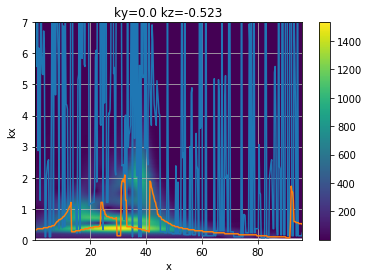

In [27]:
for i in range(0,len(kxplotlist)):
    #plot what kx would need to be given ky kz along some 
    k = [kxlist[i],kylist[i],kzlist[i]]
    xxvals = []
    kxvals = []

    kz, ky, bxkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bx')
    kz, ky, bykzkyx = anl._ffttransform_in_yz(dfieldsfluc,'by')
    kz, ky, bzkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bz')

    for xidx in range(0,len(dfields['bz_xx'])):
        B0 = anl.get_B0(dfields,xxidx)
        
        xxidx = xidx
        kperp = anl._get_perp_component(k,B0)

        #find nearest discrete point in (x,ky,kz) space we have data for
        kyidx = ao.find_nearest(ky,k[1])
        kzidx = ao.find_nearest(kz,k[2])
        kyperpidx = ao.find_nearest(ky,kperp[1])
        kzperpidx = ao.find_nearest(kz,kperp[2])

        #finalize transform into k space i.e. compute B(kx0,kz0,ky0) from B(x,kz,ky) for k and k perp
        #note: we never have an array B(kx,ky,kz), just that scalar quantities at k0 and kperp0, which we get from
        # the just for B(x,kz,ky) as computing the entire B(kx,ky,kz) array would be computationally expensive.
        # would have to perform wavelet transform for each (ky0,kz0)
        kx, bxkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],bxkzkyx[:,kzidx,kyidx]) #note kx is that same for all 6 returns here
        kx, bykz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],bykzkyx[:,kzidx,kyidx])
        kx, bzkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],bzkzkyx[:,kzidx,kyidx])
        kx, bxperpkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],bxkzkyx[:,kzperpidx,kyperpidx])
        kx, byperpkz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],bykzkyx[:,kzperpidx,kyperpidx])
        kx, bzperpkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],bzkzkyx[:,kzperpidx,kyperpidx])

        kxidx = ao.find_nearest(kx,np.abs(k[0])) #WLT can not find negative kx. Instead we assume symmetry by taking np.abs
        kxperpidx = ao.find_nearest(kx,np.abs(kperp[0]))

        if(k[0] < 0): #use reality condition to correct for the fact that we cant compute negative kx using the wlt
            bxkz0ky0kxxx = np.conj(bxkz0ky0kxxx)
            bykz0ky0kxxx = np.conj(bykz0ky0kxxx)
            bzkz0ky0kxxx = np.conj(bzkz0ky0kxxx)
            bxperpkz0ky0kxxx = np.conj(bxperpkz0ky0kxxx)
            byperpkz0ky0kxxx = np.conj(byperpkz0ky0kxxx)
            bzperpkz0ky0kxxx = np.conj(bzperpkz0ky0kxxx)

        kcrossB0 = np.cross(k,B0)
        delB = [bxkz0ky0kxxx[kxidx,xxidx],bykz0ky0kxxx[kxidx,xxidx],bzkz0ky0kxxx[kxidx,xxidx]]
        delBperp = [bxperpkz0ky0kxxx[kxperpidx,xxidx],byperpkz0ky0kxxx[kxperpidx,xxidx],bzperpkz0ky0kxxx[kxperpidx,xxidx]]

        kxvals.append(anl.predict_kx_alfven(xxidx,k,kx,B0,bxperpkz0ky0kxxx,byperpkz0ky0kxxx,bzperpkz0ky0kxxx))
        xxvals.append(dfields['bz_xx'][xidx])
    pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', plotstrongestkx = True, ylim = [0,7], xxline = xxvals, yyline = kxvals)
    pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = "ky0"+str(kylist[i])+"kz0"+str(kzlist[i])+'wltkxprediction.png', plotstrongestkx = False, ylim = [0,7], xxline = xxvals, yyline = kxvals)

In [1246]:
dfieldsfluc['bx_xx'][167]

41.875

In [1175]:
kylist

[0.0,
 0.5235987755982988,
 0.5235987755982988,
 -0.5235987755982988,
 -0.5235987755982988,
 0.0,
 0.0,
 0.5235987755982988,
 0.5235987755982988,
 -0.5235987755982988,
 -0.5235987755982988,
 0.0]

In [1176]:
A = [1+1j,1+1j,1+1j]
np.vdot(A,A)

(6+0j)

### Look at spatial structure of delB dot B0 and other plotted quantities

In [1055]:
#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

dbperpdotkcrossb0list = []
dbdotb0list = []
dbdotklist = []
for i in range(0,len(dfields['bz_xx'])):
    print(str(i) + ' of ' + str(len(dfieldsfluc['bz_xx'])))
    #test given k's
    results,_ = anl.alfven_wave_check(dfields,dfieldsfluc,[klist[0]],dfieldsfluc['bz_xx'][i])

    #build and make table
    results_vals = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
    dbperpdotkcrossb0list.append(results_vals[0][0])
    dbdotb0list.append(results_vals[0][1])
    dbdotklist.append(results_vals[0][2])
    


0 of 384
1 of 384
2 of 384
3 of 384
4 of 384
5 of 384
6 of 384
7 of 384
8 of 384
9 of 384
10 of 384
11 of 384
12 of 384
13 of 384
14 of 384
15 of 384
16 of 384
17 of 384
18 of 384
19 of 384
20 of 384
21 of 384
22 of 384
23 of 384
24 of 384
25 of 384
26 of 384
27 of 384
28 of 384
29 of 384
30 of 384
31 of 384
32 of 384
33 of 384
34 of 384
35 of 384
36 of 384
37 of 384
38 of 384
39 of 384
40 of 384
41 of 384
42 of 384
43 of 384
44 of 384
45 of 384
46 of 384
47 of 384
48 of 384
49 of 384
50 of 384
51 of 384
52 of 384
53 of 384
54 of 384
55 of 384
56 of 384
57 of 384
58 of 384
59 of 384
60 of 384
61 of 384
62 of 384
63 of 384
64 of 384
65 of 384
66 of 384
67 of 384
68 of 384
69 of 384
70 of 384
71 of 384
72 of 384
73 of 384
74 of 384
75 of 384
76 of 384
77 of 384
78 of 384
79 of 384
80 of 384
81 of 384
82 of 384
83 of 384
84 of 384
85 of 384
86 of 384
87 of 384
88 of 384
89 of 384
90 of 384
91 of 384
92 of 384
93 of 384
94 of 384
95 of 384
96 of 384
97 of 384
98 of 384
99 of 384
100 of 384

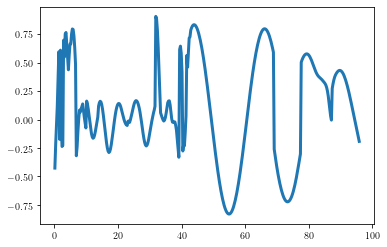

In [1056]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.real(dbperpdotkcrossb0list))
plt.show()

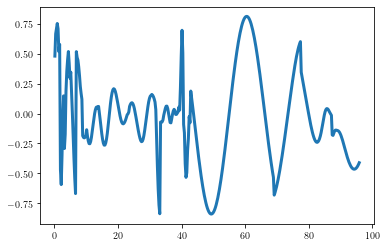

In [1057]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.imag(dbperpdotkcrossb0list))
plt.show()

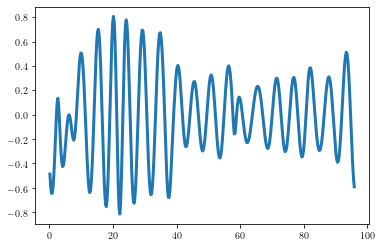

In [1058]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.real(dbdotb0list))
plt.show()

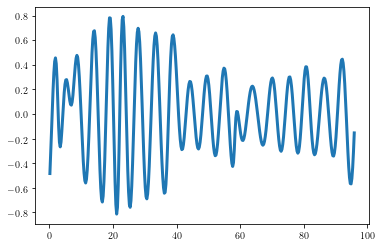

In [1059]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.imag(dbdotb0list))
plt.show()

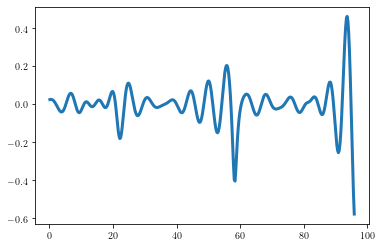

In [1060]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.real(dbdotklist))
plt.show()

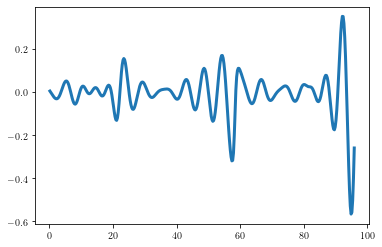

In [1061]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.imag(dbdotklist))
plt.show()

In [1062]:
np.sum(dbdotklist)

(-1.1858166441162152-3.2751171709540503j)

### Looks like we need to find local maximum instead of absolute maxima and see if any of those are alfvenic

In [499]:
wlttemp = wltplotlist[0]
xx = dfields['bz_xx']
xidx = ao.find_nearest(xx,90)
wltslice = np.abs(wlttemp[:,xidx])


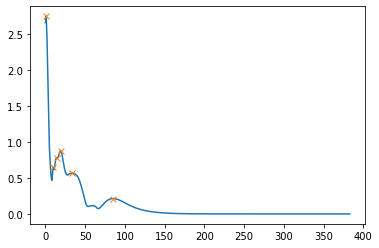

[1, 10, 14, 19, 33, 85]

In [500]:
ao.find_local_maxima(wltslice,threshold = .05,pltdebug = True)

In [785]:
ao.find_nearest([0,3,-1,4,-2,23],4.2)

3

In [1095]:
#dpar['p1'][gptsparticle][:]
A = np.asarray([1,3,4,5])
#gfieldptsx = (x1 <= dfields[fieldkey+'_xx'])
gA = (2 <= A)

In [1096]:
gA

array([False,  True,  True,  True])

In [1099]:
B = A[gA][:]

In [1100]:
B

array([3, 4, 5])